In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/complaints.csv'

# IMPORTING LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

from scipy.stats import randint

from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# DATA EXPLORATION

In [4]:
df = pd.read_csv(file_path)
df.head().T

<ipython-input-4-3259691432>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,0,1,2,3,4
Date received,2025-05-23,2025-05-23,2025-04-18,2025-06-08,2025-06-08
Product,Debt collection,Debt collection,Credit reporting or other personal consumer re...,Debt collection,Credit reporting or other personal consumer re...
Sub-product,I do not know,Credit card debt,Credit reporting,I do not know,Credit reporting
Issue,Attempts to collect debt not owed,Written notification about debt,Incorrect information on your report,Attempts to collect debt not owed,Problem with a company's investigation into an...
Sub-issue,Debt was result of identity theft,Didn't receive enough information to verify debt,Information belongs to someone else,Debt was result of identity theft,Problem with personal statement of dispute
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,"CCS Financial Services, Inc.",Lockhart Mediation Services,Experian Information Solutions Inc.,"EQUIFAX, INC.","EQUIFAX, INC."
State,TX,IL,TX,GA,TX
ZIP code,75006,62206,76114,30296,76542


In [5]:
df.count()

,0
Date received,9408224
Product,9408224
Sub-product,9172929
Issue,9408218
Sub-issue,8571124
Consumer complaint narrative,2933737
Company public response,4736589
Company,9408224
State,9353948
ZIP code,9377996


In [6]:
df.shape

(9408224, 18)

In [7]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(2933737, 2)

In [8]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

np.float64(31.2)

In [9]:
pd.DataFrame(df.Product.unique()).values

array([['Debt collection'],
       ['Credit reporting or other personal consumer reports'],
       ['Money transfer, virtual currency, or money service'],
       ['Mortgage'],
       ['Checking or savings account'],
       ['Credit card'],
       ['Vehicle loan or lease'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Student loan'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Consumer Loan'],
       ['Credit card or prepaid card'],
       ['Bank account or service'],
       ['Payday loan'],
       ['Credit reporting'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

# DATA PREPROCESSING

In [10]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [11]:
# Renaming categories
df2.replace({'Product':
            {'Credit reporting or other personal consumer reports': 'Credit reporting, repair, or other',
                'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
                'Credit card or prepaid card': 'Credit card or prepaid card',
                'Debt collection': 'Debt collection',
                'Mortgage': 'Mortgage',
                'Checking or savings account': 'Consumer Loan',
                'Vehicle loan or lease': 'Consumer Loan',
                'Credit card': 'Credit card or prepaid card',
                'Payday loan, title loan, or personal loan': 'Consumer Loan',
                'Student loan': 'Consumer Loan',
                'Money transfer, virtual currency, or money service': 'Consumer Loan',
                'Payday loan, title loan, personal loan, or advance loan': 'Consumer Loan',
                'Debt or credit management': 'Credit reporting, repair, or other',
                'Prepaid card': 'Credit card or prepaid card',
                'Credit reporting': 'Credit reporting, repair, or other',
                'Consumer Loan': 'Consumer Loan',
                'Bank account or service': 'Consumer Loan',
                'Payday loan': 'Consumer Loan',
                'Money transfers': 'Consumer Loan',
                'Other financial service': 'Credit reporting, repair, or other',
                'Virtual currency': 'Credit reporting, repair, or other'}},
            inplace= True)

In [12]:
pd.DataFrame(df2.Product.unique())

,0
0,Credit card or prepaid card
1,Debt collection
2,"Credit reporting, repair, or other"
3,Consumer Loan
4,Mortgage


In [13]:
# The number of classes were reduced from 22 to 5.
# Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

# VISUALISING PROCESSED DATA

In [14]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
7862630,Credit card or prepaid card,Chase credit card services received my properl...,0
7025192,Debt collection,I am being contacted at my place of employment...,1
3958508,"Credit reporting, repair, or other",I have been patiently waiting on their respons...,2
4608670,"Credit reporting, repair, or other",XXXX XXXX XXXX XXXX XXXX continues to report i...,2
882962,"Credit reporting, repair, or other",I am submitting this report to address incorre...,2


<ipython-input-15-533021937>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


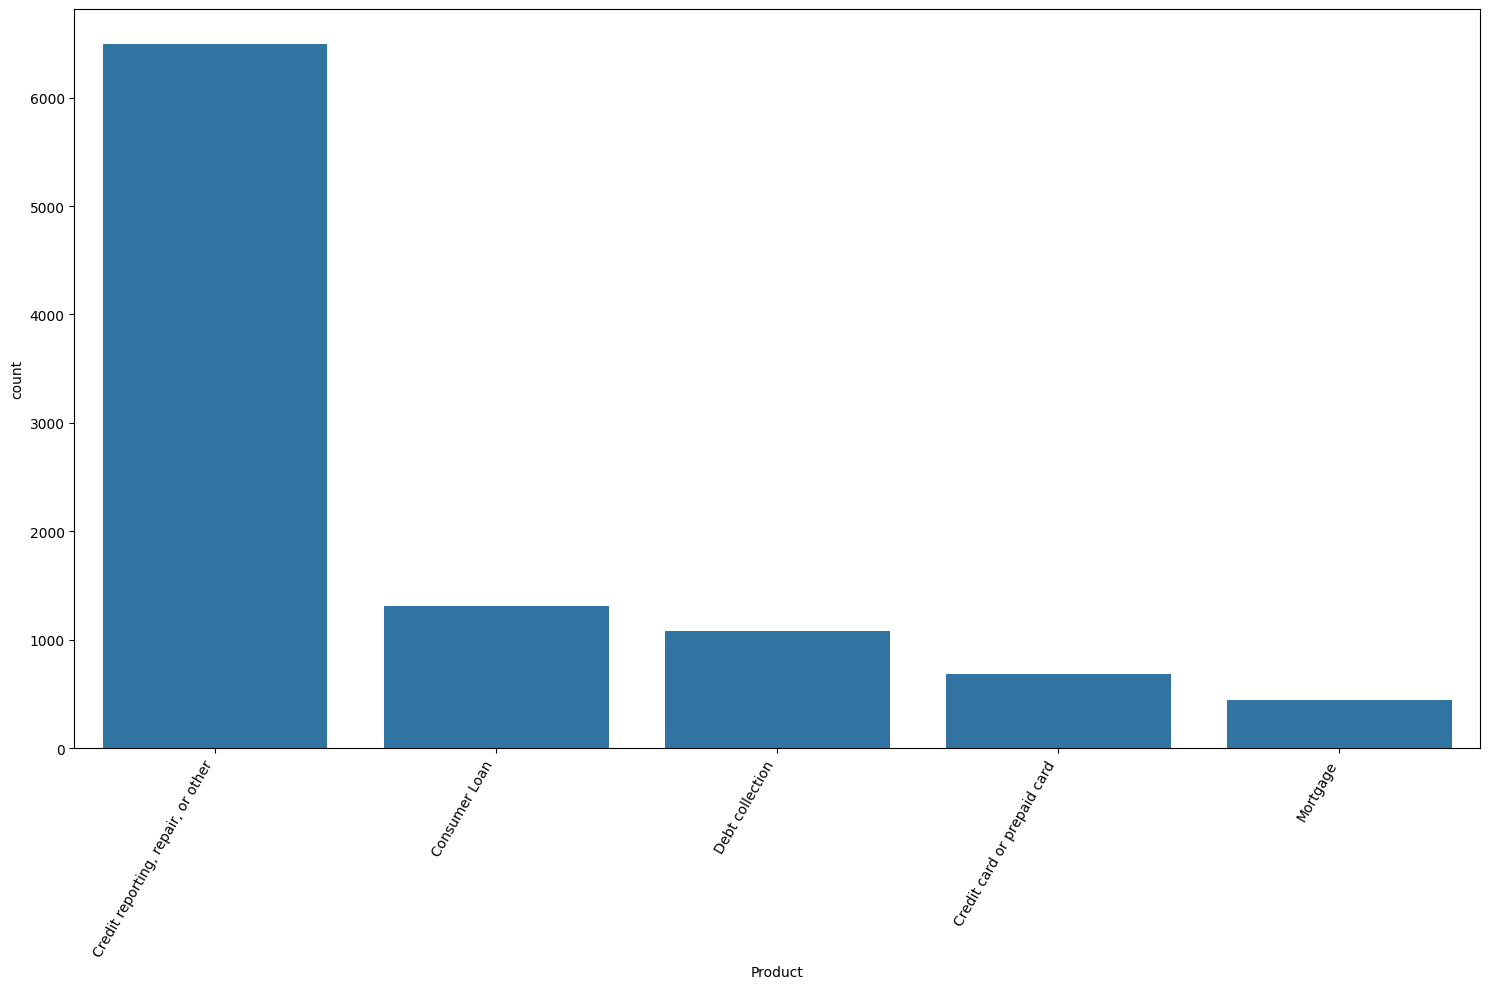

Product
Credit reporting, repair, or other    6493
Consumer Loan                         1309
Debt collection                       1076
Credit card or prepaid card            680
Mortgage                               442
Name: count, dtype: int64


In [15]:
value_counts = df2['Product'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x='Product', data=df2, order=value_counts.index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

plt.tight_layout()
plt.show()

print(value_counts)

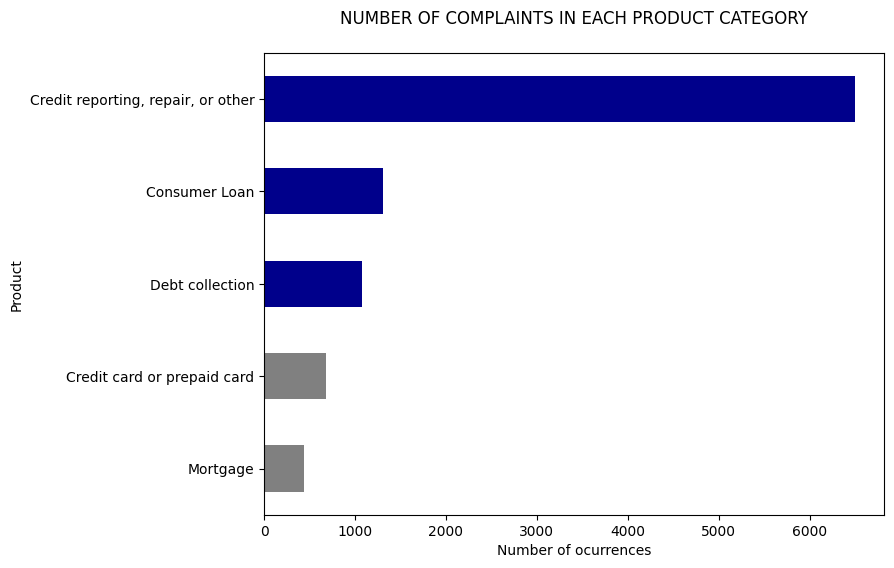

In [16]:
fig = plt.figure(figsize=(8,6))

colors = ['grey','grey','darkblue','darkblue','darkblue']

df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')

plt.xlabel('Number of ocurrences', fontsize = 10);

# TEXT DATA PREPROCESSING AND FEATURE ENGINEERING USING TF-IDF VECTORIZATION

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 25193 features (TF-IDF score of unigrams and bigrams)


In [18]:
# Number of top correlated terms to display
N = 3

# Loop through categories
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])

    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("\n==> %s:" % (Product))
    print("  * Most Correlated Unigrams are: %s" % (', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" % (', '.join(bigrams[-N:])))


==> Consumer Loan:
  * Most Correlated Unigrams are: cash, app, funds
  * Most Correlated Bigrams are: act efta, transfer act, cash app

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: rewards, chase, card
  * Most Correlated Bigrams are: new card, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: called, told, bank
  * Most Correlated Bigrams are: reporting agency, consumer reporting, credit report

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collection agency, collect debt

==> Mortgage:
  * Most Correlated Unigrams are: modification, escrow, mortgage
  * Most Correlated Bigrams are: escrow account, loan modification, mortgage company


In [19]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 5 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

# MODEL BUILDING AND EVALUATION

In [20]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=1000)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [21]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']

acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8750,0.001768
LogisticRegression,0.8642,0.004222
MultinomialNB,0.7753,0.003650
RandomForestClassifier,0.6631,0.001636


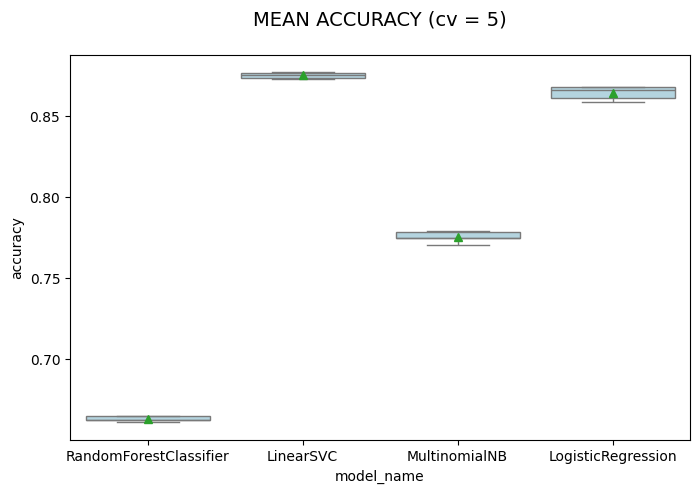

In [22]:
plt.figure(figsize=(8,5))

sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)

plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, df2.index, test_size=0.25,random_state=1, stratify=labels
)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [24]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                    precision    recall  f1-score   support

       Credit card or prepaid card       0.77      0.67      0.71       170
                   Debt collection       0.79      0.59      0.68       269
Credit reporting, repair, or other       0.91      0.95      0.93      1623
                     Consumer Loan       0.80      0.84      0.82       327
                          Mortgage       0.90      0.82      0.86       111

                          accuracy                           0.88      2500
                         macro avg       0.83      0.78      0.80      2500
                      weighted avg       0.87      0.88      0.87      2500



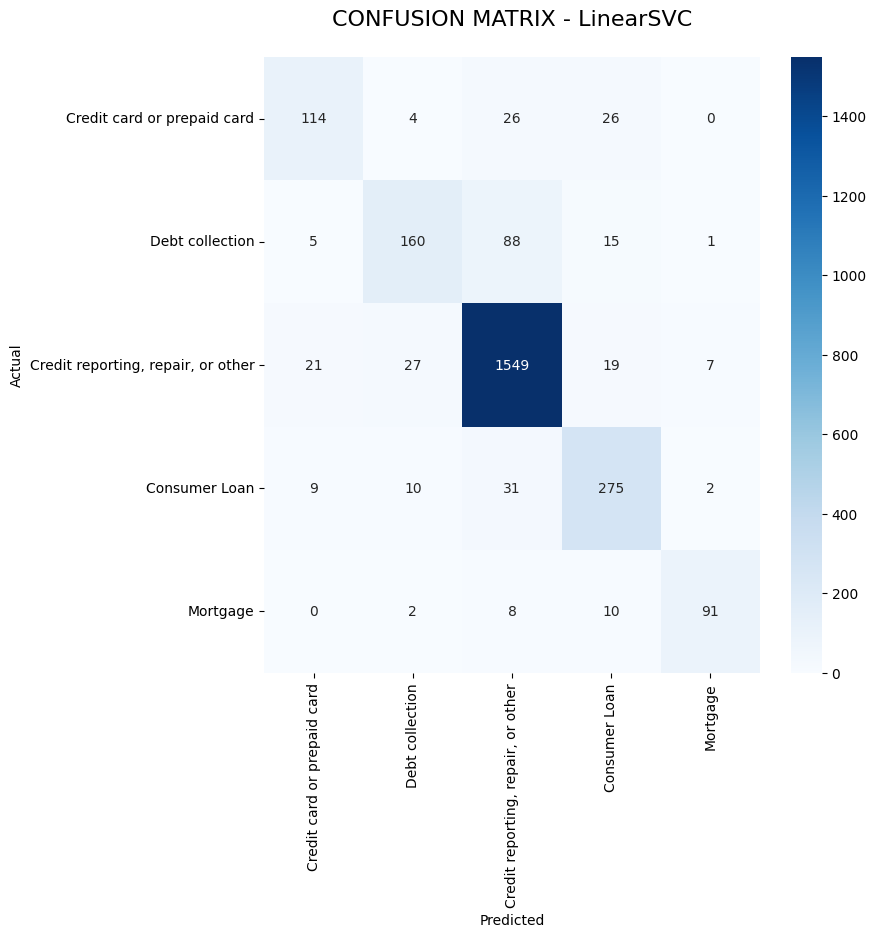

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [26]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 21 examples.


,Product,Consumer_complaint
4369503,"Credit reporting, repair, or other",A credit card was opened in my name by someone...
5477576,"Credit reporting, repair, or other",There are several cards on my report that I ha...
838565,"Credit reporting, repair, or other",I affirm that the inclusion of incorrectly rep...
3405107,"Credit reporting, repair, or other",I opened a XXXX XXXX store card in XXXX of XXX...
2341642,"Credit reporting, repair, or other",I want this late payment remove from my accoun...
5664670,"Credit reporting, repair, or other",When I noticed my credit score fell from XXXX ...
5676809,"Credit reporting, repair, or other","hi there, My names XXXX XXXX on XXXX XXXX, 201..."
5166877,"Credit reporting, repair, or other",CREDIT CARD WAS OPEN WITHOUT MY KNOWLEDGE
2189726,"Credit reporting, repair, or other",The account with XXXX had to be closed because...
3470016,"Credit reporting, repair, or other",I was told by a company representative that he...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 27 examples.


,Product,Consumer_complaint
800119,"Credit reporting, repair, or other",I mailed NCD Financial LLC several letters sin...
1798240,"Credit reporting, repair, or other",I disputed a debt with Equifax-stating the col...
1564638,"Credit reporting, repair, or other",Called the Company not able to reach at all. F...
5517667,"Credit reporting, repair, or other",I called XXXX concerning my dispute status up...
5977025,"Credit reporting, repair, or other","This is a medical bill incurred in XX/XX/XXXX,..."
2660311,"Credit reporting, repair, or other",XXXX XXXX XXXX XXXX XXXX & PORTFOLIO RECOVERY ...
3417098,"Credit reporting, repair, or other",After reviewing the Fair Debt Collection Pract...
5861990,"Credit reporting, repair, or other",I have written letters to XXXX XXXX letting th...
8800059,"Credit reporting, repair, or other",FCRA violations : accounts not mine XXXX Poten...
8939507,"Credit reporting, repair, or other",A debt was listed on my credit report by XXXX ...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 26 examples.


,Product,Consumer_complaint
6326493,Credit card or prepaid card,XXXX.I have never had an account with this com...
1380124,Credit card or prepaid card,I have a problem with XXXX. I did the document...
8801803,Credit card or prepaid card,I recently pulled my credit report & found som...
8157528,Credit card or prepaid card,For months I have not received my credit card ...
4292494,Credit card or prepaid card,See the attached documents. I want the bureau ...
6076931,Credit card or prepaid card,Capital One Bank is currently reporting 3 unau...
1404238,Credit card or prepaid card,This CFPB complaint has been filed to request ...
7645828,Credit card or prepaid card,I was shocked when reviewing my credit report ...
6521506,Credit card or prepaid card,I've been a victim of identity theft and have ...
7049940,Credit card or prepaid card,Received notice of account closure - no reason...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 88 examples.


,Product,Consumer_complaint
3837581,Debt collection,""" n accordance win the Fair Credit Reporting a..."
7222188,Debt collection,To Whom it May Concern : After viewing a copy ...
6442849,Debt collection,This debt was being sent to a wrong address on...
8568353,Debt collection,I was paying {$30.00} for over 9 years.online ...
6259063,Debt collection,I recently checked my Credit Report and notice...
...,...,...
8938229,Debt collection,The information provided by the creditor is in...
8042356,Debt collection,TRANSUNION Regarding Accounts : XXXX XXXX XXXX...
9362575,Debt collection,"Original credit company, XXXX XXXX XXXX ( XXX..."
5353060,Debt collection,"I received a notice from XXXX XXXX, XXXX over ..."



'Consumer Loan' predicted as 'Credit reporting, repair, or other' : 31 examples.


,Product,Consumer_complaint
8792343,Consumer Loan,I am writing to dispute inaccurate information...
5503787,Consumer Loan,Kikoff is reporting late payments which is ill...
1888205,Consumer Loan,"My information was hacked, someone hacked XXXX..."
4521290,Consumer Loan,I have to a non-traditional credit lender whic...
6250735,Consumer Loan,This is a secondary Complaint to Complaint # X...
3434524,Consumer Loan,"XXXX XXXX XXXX XXXX XXXX, MI XXXX RE : XXXX XX..."
5454805,Consumer Loan,Information on my credit report is inaccurate ...
8345822,Consumer Loan,This company has violated my consumer rights a...
2709254,Consumer Loan,"Fraudulent bank accounts from Bank of XXXX, XX..."
2086682,Consumer Loan,"On XX/XX/22, XXXX XXXX XXXX received a Cease a..."



'Credit card or prepaid card' predicted as 'Consumer Loan' : 26 examples.


,Product,Consumer_complaint
2127358,Credit card or prepaid card,I have been told by Navy Federal Credit Union ...
1789607,Credit card or prepaid card,No action taken by the company. Ive called the...
4327336,Credit card or prepaid card,"Hi, I opened the Netspend card account in appr..."
4969094,Credit card or prepaid card,I basically was offered this XXXXXXXXwhich was...
7747386,Credit card or prepaid card,Your information states that there is no fee f...
9384700,Credit card or prepaid card,I have been disputing XXXX fraudulent charges ...
6924984,Credit card or prepaid card,on the XXXX of XXXX my wallet was stolen from ...
6824467,Credit card or prepaid card,My minor son XXXX XXXX made a purchase on XXXX...
990419,Credit card or prepaid card,I have several issues with this new company th...
6928319,Credit card or prepaid card,"My name is XXXX XXXX, and I am a Capital One X..."


In [27]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Consumer Loan':
  * Top unigrams: mohela, money, navient, bank
  * Top bigrams: debit card, money account, dont use, debt card

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, rewards, amex
  * Top bigrams: payment remarks, american express, credit card, 00 months

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, transunion, experian, report
  * Top bigrams: xxxx xxxx, report account, xxxx equifax, payments xxxx

==> 'Debt collection':
  * Top unigrams: debt, collections, collection, collect
  * Top bigrams: elimination fraudulent, listed accounts, accounts report, identified multiple

==> 'Mortgage':
  * Top unigrams: mortgage, modification, home, escrow
  * Top bigrams: loan modification, mr cooper, unauthorized credit, short sale


# MODEL SELECTION AND IMPLEMENTATION

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

### PREDICTIONS

In [29]:
# FINAL PREDICTIONS ON SAMPLE COMPLAINTS

# Define sample complaint texts
complaints = [
    """My credit score suddenly dropped without any changes in my spending or payment habits. Upon checking, I found that an outdated loan account was wrongly reactivated.""",
    """I submitted a dispute regarding a fraudulent account on my credit report, but the agency hasn't responded in over 45 days. I'm worried it's damaging my credit history.""",
    """A debt collection agency has been contacting my family members and disclosing my private financial information, which is extremely distressing and unprofessional.""",
    """Despite settling the outstanding loan months ago, I continue to receive debt notices, and it's now being escalated to legal action without cause.""",
    """The loan provider changed the repayment terms after disbursing the amount, adding hidden fees and increasing the monthly EMI beyond my agreement.""",
    """I was denied a student loan due to a technical glitch on the application portal, even though I meet all eligibility criteria and submitted documents on time.""",
    """My mortgage lender increased the interest rate mid-way through my fixed-rate term without providing any justification or prior notice.""",
    """Every time I try to access my online mortgage account, I get locked out and customer service takes days to respond, delaying my payments."""
]


# Make predictions
predictions = model.predict(fitted_vectorizer.transform(complaints))

# Display results
for i, (complaint, prediction) in enumerate(zip(complaints, predictions), start=1):
    print(f"Complaint {i}:\n{complaint}\n--> Predicted Category: {prediction}\n")


Complaint 1:
My credit score suddenly dropped without any changes in my spending or payment habits. Upon checking, I found that an outdated loan account was wrongly reactivated.
--> Predicted Category: Credit reporting, repair, or other

Complaint 2:
I submitted a dispute regarding a fraudulent account on my credit report, but the agency hasn't responded in over 45 days. I'm worried it's damaging my credit history.
--> Predicted Category: Credit reporting, repair, or other

Complaint 3:
A debt collection agency has been contacting my family members and disclosing my private financial information, which is extremely distressing and unprofessional.
--> Predicted Category: Debt collection

Complaint 4:
Despite settling the outstanding loan months ago, I continue to receive debt notices, and it's now being escalated to legal action without cause.
--> Predicted Category: Debt collection

Complaint 5:
The loan provider changed the repayment terms after disbursing the amount, adding hidden fe